Python for optical spectroscopy data analysis workshop

By Alex Stuart (anstuart11@gmail.com)

First, we load in the packages we might need. You will need to install numpy, scipy, matplotlib, and ipympl if you have not already.

In [192]:
#packages we might need:
import numpy as np # Numerical Python library
import matplotlib as mpl # Plotting library
import matplotlib.pyplot as plt # PyPlot from matplotlib
from scipy.optimize import curve_fit # for fitting
from scipy import signal # for fft convolution
from scipy.integrate import solve_ivp

from matplotlib.colors import TwoSlopeNorm # for fixing white to 0 in contour plots


#The line below is for interactive pplots in jupyter lab. Comment out the line below if you're using jupyter notebook instead, or if it's giving you issues.
%matplotlib widget  

# Basic example: Time resolved fluorescence

## Load data

Load in some time resolved fluroescence data: (This csv file stores the times in the first row, and the data in the second row)

In [27]:
data=np.genfromtxt('time_resolved_fluorescence_1.csv',delimiter=',') # Load in csv file
# print(data) # Lets print to see what it looks like

## Plot data

Start by making a very basic plot:

Text(0, 0.5, 'Intensity')

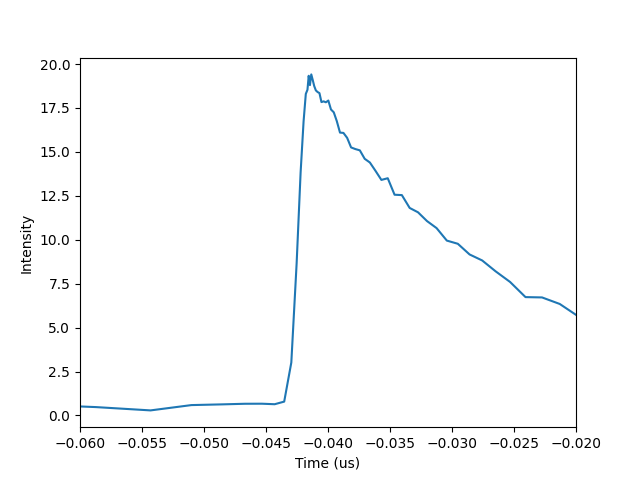

In [28]:
fig= plt.figure()
plt.plot(data[0,1:],data[1,1:])
plt.xlim(-0.06,-0.02)
plt.xlabel('Time (us)')
plt.ylabel('Intensity')

## Time zero correction, background subtraction, prettier plot

Now let's correct for time 0 (just by manually inspecting where it is):

Text(0, 0.5, 'Intensity')

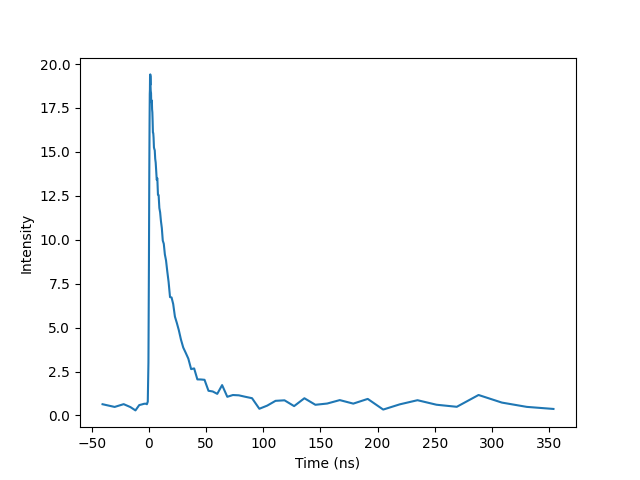

In [29]:
t=(data[0,1:]+0.0425)*1000  #correct for time zero, convert to ns
fig= plt.figure()
plt.plot(t,data[1,1:])
# plt.xlim(-0.05,0.05) # if you don't have interactive plots can adjust x window to zoom in
plt.xlabel('Time (ns)')
plt.ylabel('Intensity')
# plt.ylim(0,1.5)

Now let's subtract the background:

10
-1.0326999999999975


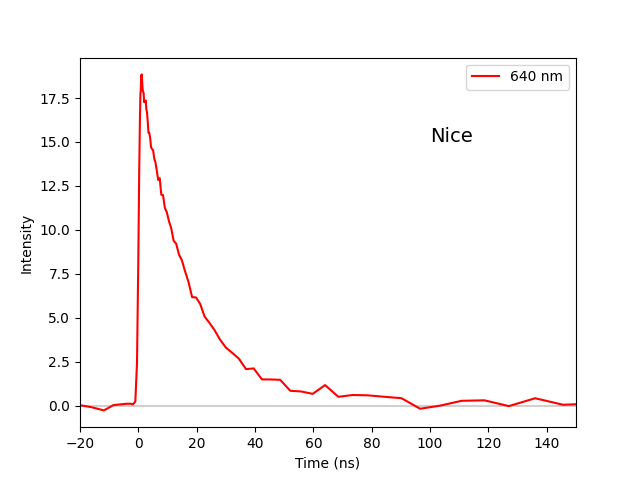

In [30]:
# lets average the background from -50 to -1 ns: 
# trick to find the where -1 is in t:
t_index=np.argmin(np.abs(t - -1))
print(t_index)
print(t[t_index])
#find and subtract the background:
background=np.mean(data[1,1:t_index])
data_b=data[1,1:]-background

#make nice plot
fig= plt.figure()
plt.axhline(0, c="#d0d0d0")
plt.plot(t,data_b,c='red',label='640 nm')
plt.xlim(-20,150) 
plt.xlabel('Time (ns)')
plt.ylabel('Intensity')
plt.legend()
plt.text(100,15,'Nice',fontsize=14)
plt.savefig('Figure.pdf')

## Fitting to exponentials

We can fit the decay to a simple exponential function:

In [7]:
#find first non negative time:
t_index=np.argmin(np.abs(t - 0))
print(t_index)
print(t[t_index])

# print(t[13])

12
-0.02920000000000006


time constant is 17.83610944054657  ps
with std error of 0.4771585412884809 ps
amplitude is 18.967115018225737
with std error of 0.18573620210423802


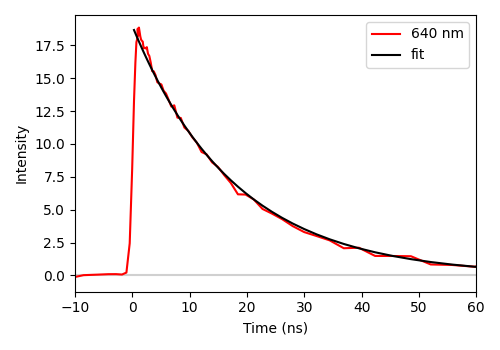

In [40]:
#Need to first define the model

def single_exp(t, tau,A): #Define a function with the inputs tau (time constant) and A (amplitude) which will be varied to fit the data.
    fit=A*np.exp(-t/tau)
    return fit

#fit using curvefit. 
popt, pcov=curve_fit(single_exp,t[13:],data_b[13:])

#plot:
fig=plt.figure(figsize=(5, 3.5))
plt.axhline(0, c="#d0d0d0")
plt.plot(t,data_b,c='red',label='640 nm')
plt.plot(t[13:],single_exp(t[13:],popt[0],popt[1]),'-',c='black',label='fit')
plt.xlabel('Time (ns)')
plt.xlim([-10,60])     
plt.ylabel('Intensity')
plt.legend()
plt.tight_layout()

#print fitted values:
print('time constant is',popt[0],' ps')
perr = np.sqrt(np.diag(pcov))
print('with std error of',perr[0],  'ps')

print('amplitude is',popt[1])
print('with std error of',perr[1])


We can also convolute with the instrument response function to get a more accurate result:

amplitude is 19.554513481152846
with std error of 0.06908385730143717
IRF is 0.8494584309759317  ns
with std error of 0.023831201681503857 ns
time constant is 16.77782658575677  ns
with std error of 0.15098916082703928 ns
time zero is 0.10845854436805967  ns
with std error of 0.009186007886823002 ns


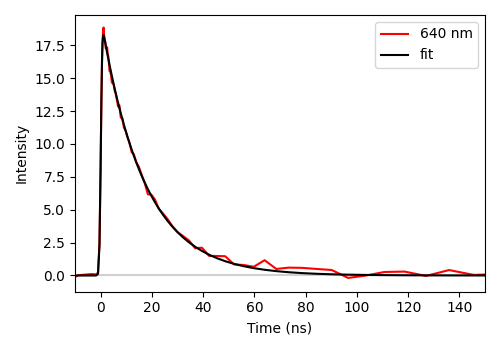

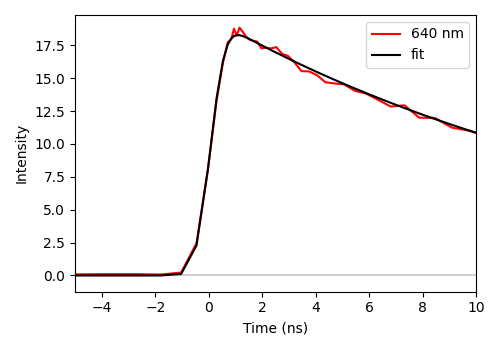

In [38]:
#Need to first define a model

def single_exp_IRF(t, tau,A,IRF,t0): #Note I've added extra fitting parameters of t0, and the IRF width
    #convolve with IRF:
    #define evenly spaced grid, with spaces smaller than the iRF
    t2=np.arange(0,t[-1],0.1)
    #calcualte exponential:
    y=A*np.exp(-t2/tau)
    #define the IRF: (A gaussian with FWHM= IRF)
    irfGauss=np.exp(-((t2-10-t0)*2*np.log(2)/IRF)**2)
    #convolve
    sig=signal.fftconvolve(irfGauss, y, mode='full')
    #crop and normalise
    sig2=sig[0:len(t2)]/np.sum(irfGauss)
    #interpolate back onto experimental time grid
    sig3=np.interp(t,t2-10,sig2)
    return sig3

#fit using curvefit. Curve fit is still good for 3 variable, but if you start getting more complicated may want to change to lmfit. 
popt, pcov=curve_fit(single_exp_IRF,t,data_b,p0=[18,20,1.1,0.08])
perr = np.sqrt(np.diag(pcov))  # this error is 1 standard deviation

# plot long time scale:
fig=plt.figure(figsize=(5, 3.5))
plt.axhline(0, c="#d0d0d0")
plt.plot(t,data_b,c='red',label='640 nm')
plt.plot(t,single_exp_IRF(t,popt[0],popt[1],popt[2],popt[3]),'-',c='black',label='fit')
plt.xlabel('Time (ns)')
plt.xlim([-10,150])     
plt.ylabel('Intensity')
plt.legend()
plt.tight_layout()

#plot shorter time scale:
fig=plt.figure(figsize=(5, 3.5))
plt.axhline(0, c="#d0d0d0")
plt.plot(t,data_b,c='red',label='640 nm')
plt.plot(t,single_exp_IRF(t,popt[0],popt[1],popt[2],popt[3]),'-',c='black',label='fit')
plt.xlabel('Time (ns)')
plt.xlim([-5,10])     
plt.ylabel('Intensity')
plt.legend()
plt.tight_layout()

#print fitted values:
print('amplitude is',popt[1])
print('with std error of',perr[1])

print('IRF is',popt[2],' ns')
perr = np.sqrt(np.diag(pcov))
print('with std error of',perr[2],  'ns')

print('time constant is',popt[0],' ns')
print('with std error of',perr[0],  'ns')

print('time zero is',popt[3],' ns')
print('with std error of',perr[3],  'ns')


Note that we (tried) to correct t0 manually, but a slight adjustment was still needed to fit perfectly. 

We can also see how much we underestimated the rate of decay when the rise of the signal was not accounted for by convoluting with the IRF - the time constant changed from 17.8 to 16.8 ns. For faster decays this discrepency will get even bigger.

We can also add multiple exponentials (not necessary for this data, but just to illustrate)

amplitude 1 is 18.965722579889654
with std error of 0.2311721849625092
time constant 1 is 17.41338355867006  ns
with std error of 0.26425475857920155  ns
amplitude 2 is 1.4543387559677357
with std error of 0.3688770390327376
time constant 2 is 18.965722579889654  ns
with std error of 0.2311721849625092  ns
IRF is 0.9030657516145013  ns
with std error of 0.028568066660216152  ns


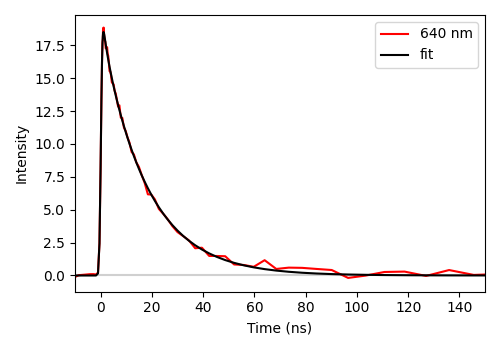

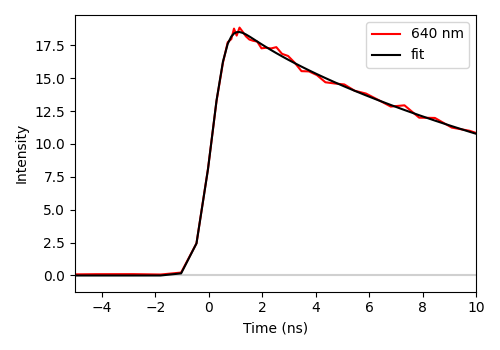

In [42]:
#Need to first define a model

def single_exp_IRF(t, tau1,A1,tau2,A2,IRF,t0):
    #convolve with IRF:
    #define evenly spaced grid, with spaces smaller than the iRF
    t2=np.arange(0,t[-1],0.1)
    #calcualte exponential:
    y=A1*np.exp(-t2/tau1)+A2*np.exp(-t2/tau2)
    #define the IRF: (A gaussian with FWHM= IRF)
    irfGauss=np.exp(-((t2-10-t0)*2*np.log(2)/IRF)**2)
    #convolve
    sig=signal.fftconvolve(irfGauss, y, mode='full')
    #crop and normalise
    sig2=sig[0:len(t2)]/np.sum(irfGauss)
    #interpolate back onto experimental time grid
    sig3=np.interp(t,t2-10,sig2)
    return sig3

#fit using curvefit. Curve fit is still good for 3 variable, but if you start getting more complicated may want to change to lmfit. 
popt, pcov=curve_fit(single_exp_IRF,t,data_b,p0=[18,20,1,1000,1.1,0.08])
perr = np.sqrt(np.diag(pcov))

# plot long time scale:
fig=plt.figure(figsize=(5, 3.5))
plt.axhline(0, c="#d0d0d0")
plt.plot(t,data_b,c='red',label='640 nm')
plt.plot(t,single_exp_IRF(t,popt[0],popt[1],popt[2],popt[3],popt[4],popt[5]),'-',c='black',label='fit')
plt.xlabel('Time (ns)')
plt.xlim([-10,150])     
plt.ylabel('Intensity')
plt.legend()
plt.tight_layout()

#plot shorter time scale:
fig=plt.figure(figsize=(5, 3.5))
plt.axhline(0, c="#d0d0d0")
plt.plot(t,data_b,c='red',label='640 nm')
plt.plot(t,single_exp_IRF(t,popt[0],popt[1],popt[2],popt[3],popt[4],popt[5]),'-',c='black',label='fit')
plt.xlabel('Time (ns)')
plt.xlim([-5,10])     
plt.ylabel('Intensity')
plt.legend()
plt.tight_layout()

#print fitted values:
print('amplitude 1 is',popt[1])
print('with std error of',perr[1])

print('time constant 1 is',popt[0],' ns')
print('with std error of',perr[0],  ' ns')

print('amplitude 2 is',popt[3])
print('with std error of',perr[3])

print('time constant 2 is',popt[1],' ns')
print('with std error of',perr[1],  ' ns')

print('IRF is',popt[4],' ns')
perr = np.sqrt(np.diag(pcov))
print('with std error of',perr[4],  ' ns')

# More complicated example: Transient Absorption

Load in data and the different components (wavlength, time, DeltaA) into different variables so they are easier to work with.

In [122]:
# Load in csv file:
dataTA=np.genfromtxt('transient_absorption.csv',delimiter=',') 
#Separate variables into their own arrays (don't need to do this, but it helpd with readability)
time=dataTA[0,1:]*1e3 # convert from us to ns
wavelength=dataTA[1:,0]
DA=np.transpose(dataTA[1:,1:])*1e3 # convert from OD to mOD, transpose so we can perform opertations on it

#subtract background
DA=DA-np.mean(DA[0:8,:],0)


## Plotting

Plot some spectral slices:

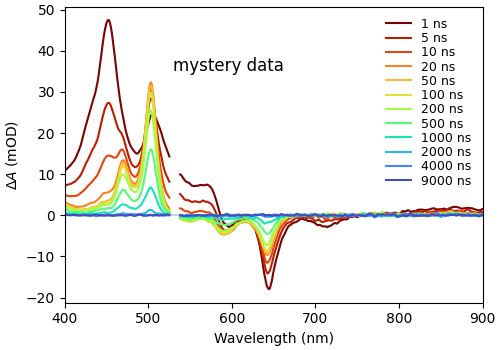

In [86]:
fig= plt.figure(figsize=(5, 3.5), constrained_layout=True) #I use the constrained layout prompt to reduce the amount of white space and make everything fit nicely

plt.axhline(0, c="#d0d0d0") #add in zero line

#set times:
timeslices=(1, 5,10, 20, 50, 100, 200, 500,1000, 2000,4000, 9000) 
index=range(0,len(timeslices),1)


#set the colormap for each time slice:
cm = mpl.colormaps.get_cmap("turbo_r")
colours = [ cm((i)/max(len(timeslices) , 1)) for i in index ] 

#loop over each time and plot:
for i in index[0:]:
    tindex=np.argmin(np.abs(time - timeslices[i])) 
    trace=DA[tindex,:]*1 #I use a *1 here so trace is a copy, not a pointer (look it up)
    # trace=np.mean(DA[tindex-1:tindex+1,:],0) #averaging over 3 data points
    plt.plot(wavelength, trace, c=colours[i], label=f"{timeslices[i]:0.0f} ns")

#add axes
plt.xlabel("Wavelength (nm)")
plt.ylabel("$\Delta A$ (mOD)")
plt.xlim(400, 900)
plt.legend(labelspacing=0.1,fontsize=9,loc='upper right',frameon=False)
#legend on outside of the plot:
#plt.legend(labelspacing=0.1,fontsize=9,bbox_to_anchor=(1.01, 0.7))
plt.text(530,35,"mystery data",color='black', fontsize=12) 
plt.savefig('TA_Figure.pdf') 

we can exclude certain areas by setting them to Nan, for example for the pump scatter around 530 nm.

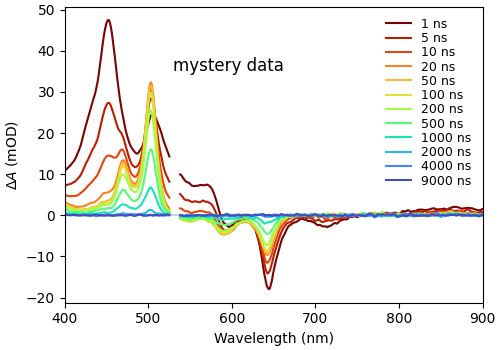

In [85]:
fig= plt.figure(figsize=(5, 3.5), constrained_layout=True) 

plt.axhline(0, c="#d0d0d0") #add in zero line

#set times:
timeslices=(1, 5,10, 20, 50, 100, 200, 500,1000, 2000,4000, 9000) 
index=range(0,len(timeslices),1)


#set the colormap for each time slice:
cm = mpl.colormaps.get_cmap("turbo_r")
colours = [ cm((i)/max(len(timeslices) , 1)) for i in index ] 

#set range we want to exclude
windex1=np.argmin(np.abs(wavelength-526))
windex2=np.argmin(np.abs(wavelength-538))

#loop over each time and plot:
for i in index[0:]:
    tindex=np.argmin(np.abs(time - timeslices[i])) 
    trace=DA[tindex,:]*1 #plot raw data
    # trace=np.mean(DA[tindex-1:tindex+1,:],0) #averaging over 3 data points
    trace[windex1:windex2]=np.nan
    plt.plot(wavelength, trace, c=colours[i], label=f"{timeslices[i]:0.0f} ns")

#add axes
plt.xlabel("Wavelength (nm)")
plt.ylabel("$\Delta A$ (mOD)")
plt.xlim(400, 900)
plt.legend(labelspacing=0.1,fontsize=9,loc='upper right',frameon=False)
#legend on outside of the plot:
#plt.legend(labelspacing=0.1,fontsize=9,bbox_to_anchor=(1.01, 0.7))
plt.text(530,35,"mystery data",color='black', fontsize=12) 
plt.savefig('TA_Figure.pdf') 

Can normalise the spectra to a given point:

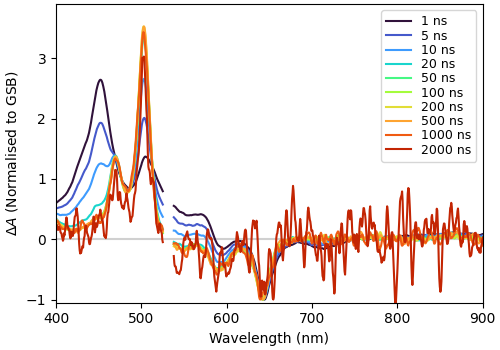

In [87]:
fig= plt.figure(figsize=(5, 3.5),constrained_layout=True) 

plt.axhline(0, c="#d0d0d0") # add in zero line

#set times:
timeslices=(1, 5,10, 20, 50, 100, 200, 500,1000, 2000) 
index=range(0,len(timeslices),1)

cm = mpl.colormaps.get_cmap("turbo") #I flipped the colormap here, just for fun.
colours = [ cm((i)/max(len(timeslices) , 1)) for i in index ] 
for i in index[0:]:
    tindex=np.argmin(np.abs(time - timeslices[i])) 
    trace=DA[tindex,:] 
    windex1=np.argmin(np.abs(wavelength-600))
    windex2=np.argmin(np.abs(wavelength-700))
    plt.plot(wavelength, trace/-np.min(trace[windex1:windex2]), c=colours[i], label=f"{timeslices[i]:0.0f} ns")

#add axes
plt.xlabel("Wavelength (nm)")
plt.ylabel("$\Delta A$ (Normalised to GSB)")
plt.xlim(400, 900)
plt.ylim(-1.05,3.9)
plt.legend(labelspacing=0.1,fontsize=9,loc='upper right')


Some times have more noise / lower signal, so we can use if/else statements to choose to average those times more:

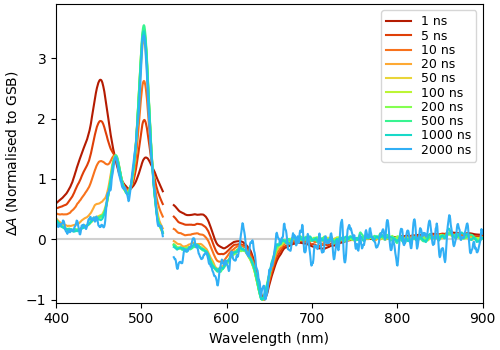

In [102]:
fig= plt.figure(figsize=(5, 3.5),constrained_layout=True) #

plt.axhline(0, c="#d0d0d0") # add in zero line

#set times:
timeslices=(1, 5,10, 20, 50, 100, 200, 500,1000, 2000) 
index=range(0,len(timeslices),1)

cm = mpl.colormaps.get_cmap("turbo_r")
colours = [ cm((i+1)/max(len(timeslices)+3 , 1)) for i in index ] 
for i in index[0:]:
    tindex=np.argmin(np.abs(time - timeslices[i])) 
    if timeslices[i]>=1000: #want to average some times more than others (lower signal)
        trace=np.mean(DA[tindex-5:tindex+5,:],0)
    else:
        trace=np.mean(DA[tindex-1:tindex+1,:],0) 
    windex1=np.argmin(np.abs(wavelength-600))
    windex2=np.argmin(np.abs(wavelength-700))
    plt.plot(wavelength, trace/-np.min(trace[windex1:windex2]), c=colours[i], label=f"{timeslices[i]:0.0f} ns")

#add axes
plt.xlabel(f"Wavelength (nm)")
plt.ylabel(f"$\Delta A$ (Normalised to GSB)")
plt.xlim(400, 900)
plt.ylim(-1.05,3.9)
plt.legend(labelspacing=0.1,fontsize=9,loc='upper right')
# ax.legend(labelspacing=0.1,fontsize=9,bbox_to_anchor=(1.01, 0.7))
# plt.text(600,14,"nice",color='black', fontsize=12) 
plt.savefig('TA_Figure_norm.pdf') 

We can do the same with time slices:

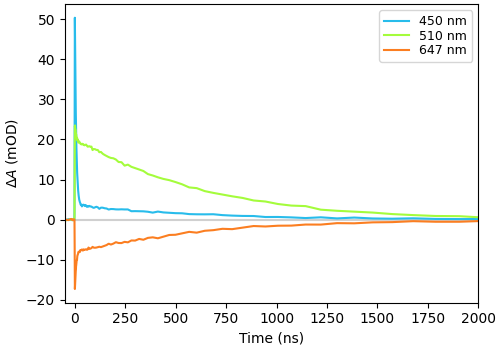

In [101]:
fig= plt.figure(figsize=(5, 3.5),constrained_layout=True)

plt.axhline(0, c="#d0d0d0") # add in zero line

#set times:
index=(0,1,2)
waveslices=(450, 510, 647) 

#set colours:
cm = mpl.colormaps.get_cmap("turbo")
colours = [ cm((i+1)/max(len(waveslices)+1 , 1)) for i in index ] 

#plot wavelengths:
for i in index[0:]:
    windex=np.argmin(np.abs(wavelength - waveslices[i])) 
    trace=np.mean(DA[:,windex-1:windex+1],1)
    plt.plot(time, trace, c=colours[i], label=f"{waveslices[i]:0.0f} nm")

#add axes
plt.xlabel(f"Time (ns)")
plt.ylabel(f"$\Delta A$ (mOD)")
plt.xlim(-50, 2000)
plt.legend(labelspacing=0.1,fontsize=9,loc='upper right')
# plt.close() #use this to suppress output if you have too many figures.

We can use subplots to plot things side by side. 

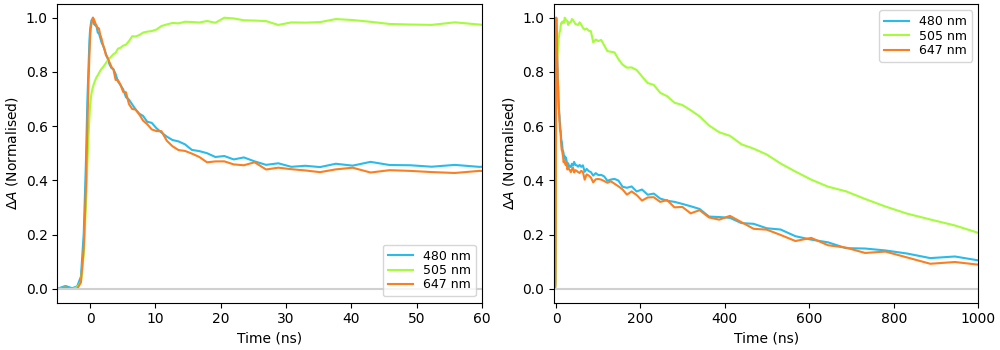

In [103]:
fig, ax= plt.subplots(1,2,figsize=(10, 3.5),constrained_layout=True) #using subplots. 

#set times:
index=(0,1,2)
waveslices=(480, 505, 647) 
#set colors:
cm = mpl.colormaps.get_cmap("turbo")
colours = [ cm((i+1)/max(len(waveslices)+1 , 1)) for i in index ] 

#plot the different wavelength traces (one for each subplot)
for i in index[0:]:
    windex=np.argmin(np.abs(wavelength - waveslices[i])) 
    trace=np.mean(DA[:,windex-1:windex+1],1)
    ax[0].plot(time, np.abs(trace)/np.max(np.abs(trace)), c=colours[i], label=f"{waveslices[i]:0.0f} nm")
    ax[1].plot(time, np.abs(trace)/np.max(np.abs(trace)), c=colours[i], label=f"{waveslices[i]:0.0f} nm")

ax[0].axhline(0, c="#d0d0d0") #add in zero line
#add axes
ax[0].set_xlabel(f"Time (ns)")
ax[0].set_ylabel(f"$\Delta A$ (Normalised)")
ax[0].set_xlim(-5, 60)
ax[0].legend(labelspacing=0.1,fontsize=9,loc='lower right')

ax[1].axhline(0, c="#d0d0d0") #add in zero line
#add axes
ax[1].set_xlabel(f"Time (ns)")
ax[1].set_ylabel(f"$\Delta A$ (Normalised)")
ax[1].set_xlim(-5, 1000)
ax[1].legend(labelspacing=0.1,fontsize=9,loc='upper right')


We can also plot a contour plot (heat map)

Text(0, 0.5, 'Time (ns)')

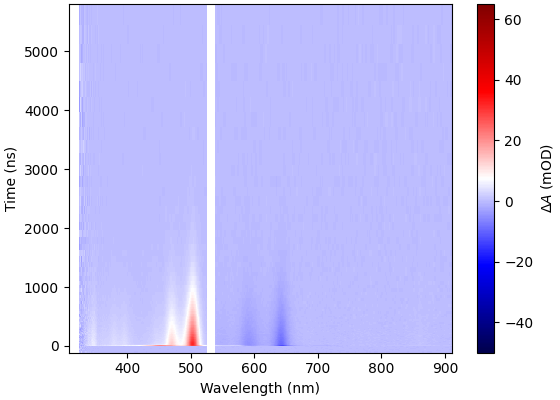

In [64]:
# Choose colour map and range of intensity values to use for plot
cmap = "seismic"
z_range = (None, None)
################################################################################ 
# Build the plot
fig, ax = plt.subplots(1, 1, figsize=(5.6,4), constrained_layout=True)
# Add an upper eV scale if wavelength in nm
# Add the heatmap plot
img = ax.pcolormesh(wavelength, time, DA, vmin=-50, vmax=65, shading="auto", cmap=cmap, rasterized=True) #v min and v max set the scaling of the color bar.

# Add colourbar scale
cb = fig.colorbar(img, ax=ax)
cb.ax.set_ylabel("$\Delta A$ (mOD)")

# Finish labelling axes etc
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Time (ns)")


# ax.text(450,7300,"(a) TIPS-Pn 0.05 mM",color='black', fontsize=12)
# pass # Hide notebook output text

it's  bit hard to see the details, so we can make it a bit clearer by changing the vmin and vmax, the y and x limits, and using a log time scale.

(-3.0, 5629.634647770085)

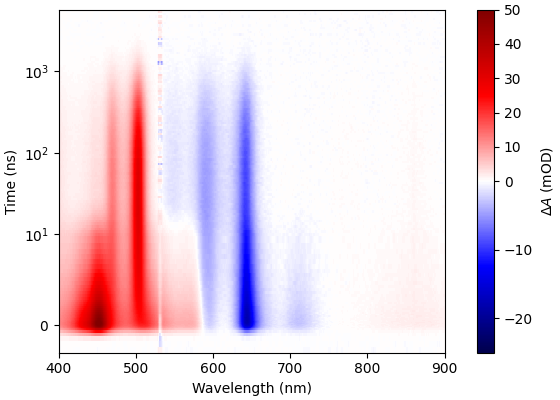

In [222]:
# Choose colour map and range of intensity values to use for plot
cmap = "seismic"
z_range = (None, None)
################################################################################ 
# Build the plot
fig, ax = plt.subplots(1, 1, figsize=(5.6,4), constrained_layout=True)
# Force the scale to have the center of the colormap (white) at zero.
norm2 = TwoSlopeNorm(vmin = -25, vcenter = 0, vmax = 50)
# Add the heatmap plot
img = ax.pcolormesh(wavelength, time, DA, norm=norm2, shading="auto", cmap=cmap, rasterized=True) #v min and v max set the scaling of the color bar.
# Add colourbar scale
cb = fig.colorbar(img, ax=ax)
cb.ax.set_ylabel("$\Delta A$ (mOD)")

# Finish labelling axes etc
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Time (ns)")
ax.set_yscale('symlog',linthresh=10) #Split linear log scale, linear until linthresh (10 ns)
ax.set_xlim(400,900)
ax.set_ylim(-3,time[-1])

# ax.text(450,7300,"(a) TIPS-Pn 0.05 mM",color='black', fontsize=12)
# pass # Hide notebook output text

## Spectral deconvolution

Often TA data will have overlapping contributions from multiple species, for example singlets, triplets, excimers, charges etc. It's nice to separate out their contributions and deconvolve the data, if you can.

In this example it is fairly easy to do. 

Let's look at the normalised plot again:

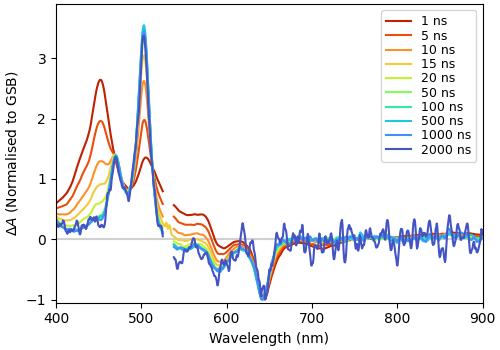

In [119]:
fig= plt.figure(figsize=(5, 3.5),constrained_layout=True) 

plt.axhline(0, c="#d0d0d0") 
timeslices=(1, 5,10, 15, 20, 50, 100, 500,1000, 2000) 
index=range(0,len(timeslices),1)
cm = mpl.colormaps.get_cmap("turbo_r")
colours = [ cm((i+1)/max(len(timeslices)+1 , 1)) for i in index ] 
for i in index[0:]:
    tindex=np.argmin(np.abs(time - timeslices[i])) 
    if timeslices[i]>=1000: 
        trace=np.mean(DA[tindex-5:tindex+5,:],0)
    else:
        trace=np.mean(DA[tindex-1:tindex+1,:],0) 
    windex1=np.argmin(np.abs(wavelength-600))
    windex2=np.argmin(np.abs(wavelength-700))
    plt.plot(wavelength, trace/-np.min(trace[windex1:windex2]), c=colours[i], label=f"{timeslices[i]:0.0f} ns")
plt.xlabel("Wavelength (nm)")
plt.ylabel("$\Delta A$ (Normalised to GSB)")
plt.xlim(400, 900)
plt.ylim(-1.05,3.9)
plt.legend(labelspacing=0.1,fontsize=9,loc='upper right')


We can see the shape changes pretty significantly over about 50 ns, indicating the conversion of one species to another. There's no shape change after then, suggesting from around 100 ns onwards, there is either just one species present or an equilibrium between two.

For this sample, we know the first species (let's call it A) is emissive, and that that emission is gone after 100 ns (from separate TCSPC experiments). So we know species A has completely decayed, and after 100 ns, we just have species B. I'll let you guess what A and B are.

We can therefore use times after 100 ns to set a basis spectrum for species B.

For species A, I'm just going to take a basis spectrum from as early a time as possible to avoid as much of species B as I can.

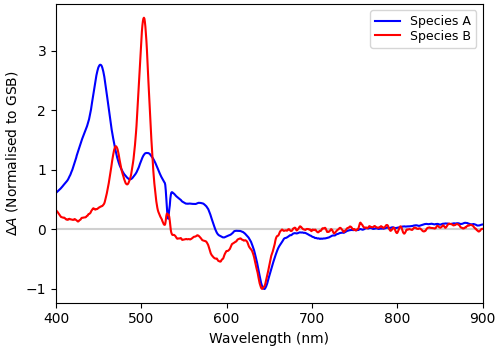

In [129]:
#I've picked 500 ns since this is early enough for a nice signal, and late enough that there should be no species A. 
tindex=np.argmin(np.abs(time - 500)) 
BS_B=np.mean(DA[tindex-1:tindex+1,:],0) #I do a little bit of averaging around 500 ns too. 

#Use 0.5 ns for Species A
tindex=np.argmin(np.abs(time - 0.5)) 
BS_A=DA[tindex,:]

#I'm also going to normalise them to the GSB
windex1=np.argmin(np.abs(wavelength-600))
windex2=np.argmin(np.abs(wavelength-700))
BS_B=BS_B/-np.min(BS_B[windex1:windex2])
BS_A=BS_A/-np.min(BS_A[windex1:windex2])


fig= plt.figure(figsize=(5, 3.5),constrained_layout=True) 
plt.axhline(0, c="#d0d0d0") 
plt.plot(wavelength, BS_A, c='blue', label='Species A')
plt.plot(wavelength, BS_B, c='red', label='Species B')
plt.xlabel("Wavelength (nm)")
plt.ylabel("$\Delta A$ (Normalised to GSB)")
plt.xlim(400, 900)
# plt.ylim(-1.05,3.9)
plt.legend(labelspacing=0.1,fontsize=9,loc='upper right')



Now we can fit a linear combination of these spectra to the data at each point in time to see how species A changes to B.

In [146]:
# Fit components to the data over appropriate window, here the data is not good outside of 400--900 nm.  
windex1=np.argmin(np.abs(wavelength - 400))
windex2=np.argmin(np.abs(wavelength - 900))

#Define a function to fit the data, here a linear combination of the basis spec. 
def Lin_comb(w,A,B): #w is just a dummy variable, not needed
    fittedA=A*BS_A[windex1:windex2]  + B*BS_B[windex1:windex2] 
    return fittedA

#Make some vectorss to store the "concentrations" of A and B, and their errors. 
C_A=np.zeros((len(time),1))
C_B=np.zeros((len(time),1))
Err_A=np.zeros((len(time),1))
Err_B=np.zeros((len(time),1))

#Now we loop over every time point, fit the linear combination with curve_fit, and store the resulting concentrations in the vectors.  
for i in range (len(time)):
    popt,pcov=curve_fit(Lin_comb,wavelength,DA[i,windex1:windex2],p0=[1,1],bounds=[0,np.inf])
    C_A[i]=popt[0]*1
    C_B[i]=popt[1]*1
    perr=np.sqrt(np.diag(pcov))
    Err_A[i]=perr[0]*1
    Err_B[i]=perr[1]*1

#reconstruct with the fitted concentrations:
DA_sim=(C_A@[BS_A] + C_B@[BS_B])



Let's plot the result of this fit at different time points to see how well it does:

Text(0.5, 0, 'Wavelength (nm)')

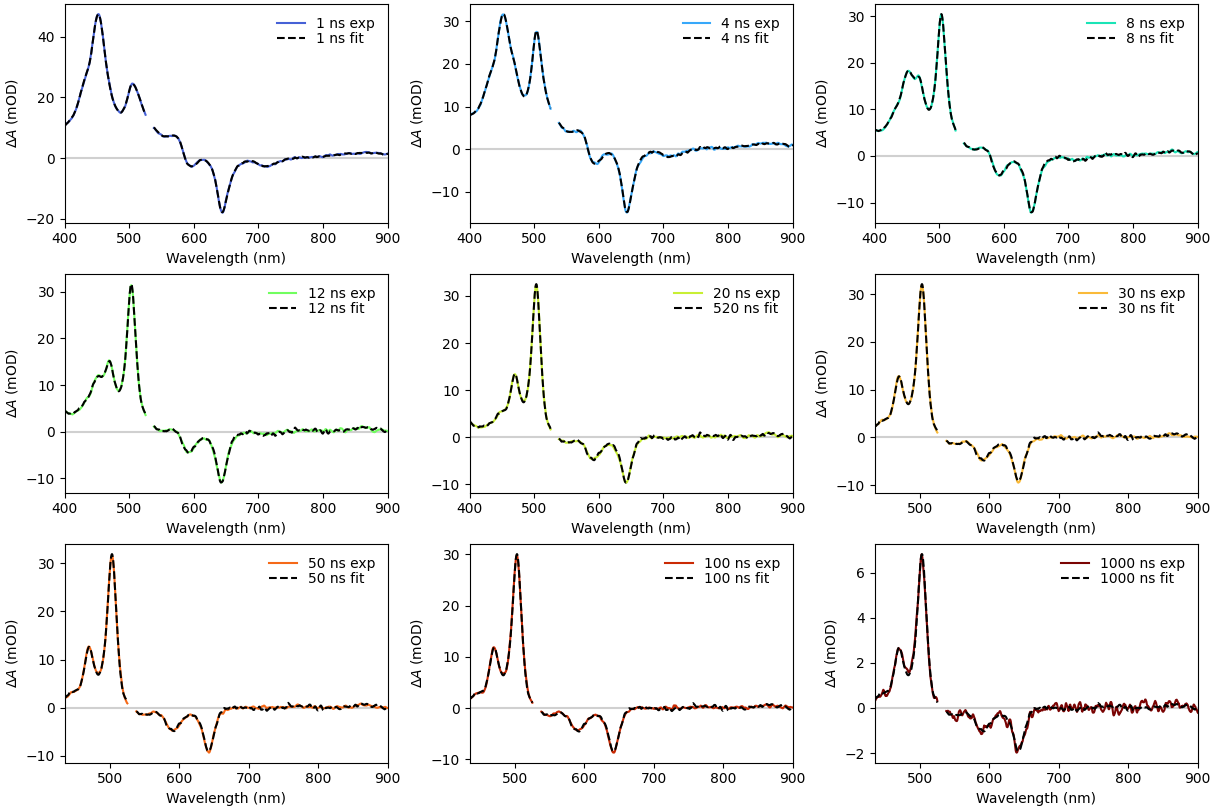

In [191]:
#set colours
cm = mpl.colormaps.get_cmap("turbo")
colours = [ cm(i/9) for i in index ]

#set scatter area to nan
windex1=np.argmin(np.abs(wavelength-526))
windex2=np.argmin(np.abs(wavelength-538))
DA_sim[:,windex1:windex2]=np.nan

DAa=DA*1 #I'm doing this so we don't change the original data
DAa[:,windex1:windex2]=np.nan

#Plot the deconvolution fits at specific times: Now I'm making this 3x3 subplots
fig, ax = plt.subplots(3, 3, figsize=(4.5*2.7, 3*2.7), constrained_layout=True)
#1 ns
ax[0,0].axhline(0, c="#d0d0d0")
tindex=np.argmin(np.abs(time - 1))
ax[0,0].plot(wavelength, DAa[tindex,:],c=colours[1], label="1 ns exp")
ax[0,0].plot(wavelength, DA_sim[tindex,:],'--',c='black', label="1 ns fit")
ax[0,0].legend(frameon=False,labelspacing=0.1,fontsize=10)
#5 ns
ax[0,1].axhline(0, c="#d0d0d0")
tindex=np.argmin(np.abs(time - 4))
ax[0,1].plot(wavelength, DAa[tindex,:],c=colours[2], label="4 ns exp")
ax[0,1].plot(wavelength, DA_sim[tindex,:],'--',c='black', label="4 ns fit")
ax[0,1].legend(frameon=False,labelspacing=0.1,fontsize=10)
#20 ns
ax[0,2].axhline(0, c="#d0d0d0")
tindex=np.argmin(np.abs(time - 8))
ax[0,2].plot(wavelength, DAa[tindex,:],c=colours[3], label="8 ns exp")
ax[0,2].plot(wavelength, DA_sim[tindex,:],'--',c='black', label="8 ns fit")
ax[0,2].legend(frameon=False,labelspacing=0.1,fontsize=10)
#200 ns
ax[1,0].axhline(0, c="#d0d0d0")
tindex=np.argmin(np.abs(time - 12))
ax[1,0].plot(wavelength, DAa[tindex,:],c=colours[4], label="12 ns exp")
ax[1,0].plot(wavelength, DA_sim[tindex,:],'--',c='black', label="12 ns fit")
ax[1,0].set_ylabel("$\Delta T/T$ (x10$^{-3}$)")
ax[1,0].legend(frameon=False,labelspacing=0.1,fontsize=10)
#2000 ns
ax[1,1].axhline(0, c="#d0d0d0")
tindex=np.argmin(np.abs(time - 20))
ax[1,1].plot(wavelength, DAa[tindex,:],c=colours[5], label="20 ns exp")
ax[1,1].plot(wavelength, DA_sim[tindex,:],'--',c='black', label="520 ns fit")
ax[1,1].legend(frameon=False,labelspacing=0.1,fontsize=10)
#3000 ns
ax[1,2].axhline(0, c="#d0d0d0")
tindex=np.argmin(np.abs(time - 30))
ax[1,2].plot(wavelength, DAa[tindex,:],c=colours[6], label="30 ns exp")
ax[1,2].plot(wavelength, DA_sim[tindex,:],'--',c='black', label="30 ns fit")
ax[1,2].legend(frameon=False,labelspacing=0.1,fontsize=10)
#10 us
ax[2,0].axhline(0, c="#d0d0d0")
tindex=np.argmin(np.abs(time - 50))
ax[2,0].plot(wavelength, DAa[tindex,:],c=colours[7], label="50 ns exp")
ax[2,0].plot(wavelength, DA_sim[tindex,:],'--',c='black', label="50 ns fit")
ax[2,0].legend(frameon=False,labelspacing=0.1,fontsize=10)
#90 us
ax[2,1].axhline(0, c="#d0d0d0")
tindex=np.argmin(np.abs(time - 100))
ax[2,1].plot(wavelength, DAa[tindex,:],c=colours[8], label="100 ns exp")
ax[2,1].plot(wavelength, DA_sim[tindex,:],'--',c='black', label="100 ns fit")
ax[2,1].legend(frameon=False,labelspacing=0.1,fontsize=10)
#180 us
ax[2,2].axhline(0, c="#d0d0d0")
tindex=np.argmin(np.abs(time - 1000))
ax[2,2].plot(wavelength, DAa[tindex,:],c=colours[9], label="1000 ns exp")
ax[2,2].plot(wavelength, DA_sim[tindex,:],'--',c='black', label="1000 ns fit")
ax[2,2].legend(frameon=False,labelspacing=0.1,fontsize=10)

ax[0,0].set_xlim(400, 900)
ax[0,1].set_xlim(400, 900)
ax[0,2].set_xlim(400, 900)
ax[1,0].set_xlim(400, 900)
ax[1,1].set_xlim(400, 900)
ax[1,2].set_xlim(435, 900)
ax[2,0].set_xlim(435, 900)
ax[2,1].set_xlim(435, 900)
ax[2,2].set_xlim(435, 900)

ax[0,0].set_ylabel("$\Delta A$ (mOD)")
ax[0,1].set_ylabel("$\Delta A$ (mOD)")
ax[0,2].set_ylabel("$\Delta A$ (mOD)")
ax[1,0].set_ylabel("$\Delta A$ (mOD)")
ax[1,2].set_ylabel("$\Delta A$ (mOD)")
ax[1,2].set_ylabel("$\Delta A$ (mOD)")
ax[2,0].set_ylabel("$\Delta A$ (mOD)")
ax[2,1].set_ylabel("$\Delta A$ (mOD)")
ax[2,2].set_ylabel("$\Delta A$ (mOD)")
ax[0,0].set_xlabel("Wavelength (nm)")
ax[0,1].set_xlabel("Wavelength (nm)")
ax[0,2].set_xlabel("Wavelength (nm)")
ax[1,0].set_xlabel("Wavelength (nm)")
ax[1,1].set_xlabel("Wavelength (nm)")
ax[1,2].set_xlabel("Wavelength (nm)")
ax[2,0].set_xlabel("Wavelength (nm)")
ax[2,2].set_xlabel("Wavelength (nm)")
ax[2,2].set_xlabel("Wavelength (nm)")



Looks pretty good, so two spectral components are sufficient to reproduce the TA data at all points in time. Now lets plot the fitted "concentrations"

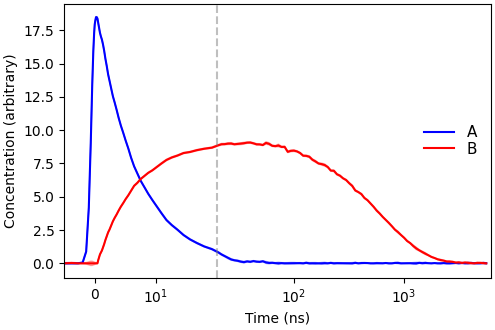

In [155]:
#Plot the concentrations
fig= plt.figure(figsize=(4.5*1.1, 3*1.1),constrained_layout=True)
plt.plot(time,C_A,c='blue',label='A')
plt.plot(time,C_B,c='red',label='B')

# We can plot the errors as shaded regions. Here I use 2*sd for ~98% confidence interval
plt.fill_between(time,C_B[:,0]-3*Err_B[:,0],C_B[:,0]+3*Err_B[:,0],color='red',alpha=0.3) 
plt.fill_between(time,C_A[:,0]-3*Err_A[:,0],C_A[:,0]+3*Err_A[:,0],color='blue',alpha=0.3)


plt.xlabel("Time (ns)")
plt.ylabel("Concentration (arbitrary)")
plt.xlim([-5,1.1*time[-1]])
# plt.ylim([0,1.36])
plt.legend(frameon=False,labelspacing=0.1,fontsize=11,loc='center right')
plt.xscale('symlog',linthresh=20)
plt.axvline(20,color='grey', alpha=0.5,ls='--')

Now we can clearly see the conversion of A to B. 
The curvefit method does not alway do the best job of calculating errors, so take these with a grain of salt. Here they are so small we can't see them unless we zoom in.

If we compare this to simply taking a TA slice at a given wavelength, e.g. the absorption at 503 nm, we can see the deconvouted concentrations are a lot more informative:

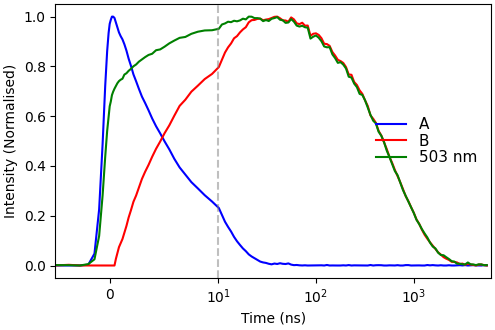

In [221]:
#Plot the concentrations
fig= plt.figure(figsize=(4.5*1.1, 3*1.1),constrained_layout=True)
plt.plot(time,C_A/np.max(C_A),c='blue',label='A')
plt.plot(time,C_B/np.max(C_B),c='red',label='B')

windex=np.argmin(np.abs(wavelength - 503)) 
trace=np.mean(DA[:,windex-1:windex+1],1)
plt.plot(time, np.abs(trace)/np.max(np.abs(trace)),'-', c='green', label="503 nm")

plt.xlabel("Time (ns)")
plt.ylabel("Intensity (Normalised)")
plt.xlim([-5,1.1*time[-1]])
# plt.ylim([0,1.36])
plt.legend(frameon=False,labelspacing=0.1,fontsize=11,loc='center right')
plt.xscale('symlog',linthresh=10)
plt.axvline(10,color='grey', alpha=0.5,ls='--')

Note that these concentrations are unitless, and we don't actually know the relative magnitude between A and B. We normalised the basis spectra to the GSB, but since the GSB overlaps with ESAs and stimulated emissions, it is unlikely the signals there are actually equal. 

There are a few ways to get the actual concentrations. For species A, you could use the absorption and the fluence of the pump to calculate how many excitons you should have excited. If there is no significant decay within your instrument response time, this will give you the initial concentration of A.

Alternatively, if the GSB does not overlap significantly with any ESAs or SEs (as in the case of B), you can use the ground-state extinction coefficient. 

Or, you could take a material with a known extinction coefficient, and do a sensitisation experiment. 


## Kinetic modelling

### Example 1

Let's assume for this system that we have worked out that A and B are actually equal at the GSB, and thus the ratio of A to B concentrations above is correct. 

We can then fit a kinetic model (system of differential equations) to work out the rate constant of conversion of A to B.

To build this model, we need to consider all the processes that can occur. For this system, A can either decay to the ground state (GS) (both radiatively and nonradiatively), or form B. B can only decay to the ground state:

$$\textrm{A} \xrightarrow{k_1} \textrm{GS}$$
$$\textrm{A} \xrightarrow{k_2} \textrm{B}$$
$$\textrm{B} \xrightarrow{k_3} \textrm{GS}$$

The rates of change of A and B thus look like:

$$\frac{d[A]}{dt}=-k_1[A]-k_2[A]$$
$$\frac{d[B]}{dt}=k_2[A]-k_3[B]$$

Below we will solve this system of differential equations, varying the rate constants $k_1$, $k_2$ and $k_3$ until the solution fits the data. 

t1 time constant is 12.34611459979995  ns with error of 0.18915015886752706  ns
t2 time constant is 15.092379329968082  ns with error of 0.1156791217889441  ns
t3 time constant is 644.2537636622246  ns with error of 11.232840092562322  ns
Initial amplitide of A is 20.98871003316588  with error of 0.11050394064413785


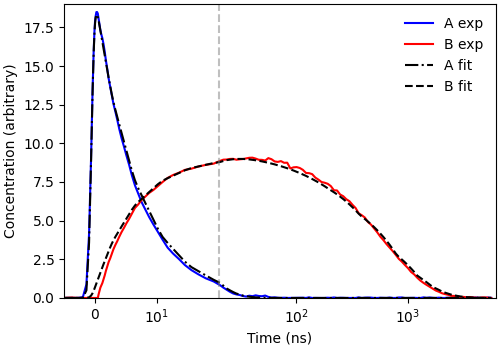

In [216]:
#define the model
def model(time,y,k1,k2,k3):
    
    #concentrations:
    A=y[0]
    B=y[1]
    
    #derivative vector (ODE system)
    dAdt= - k1*A - k2*A
    dBdt= + k2*A - k3*B
    
    return ([dAdt,dBdt])

#numerically solve the model for A and B using solve_ivp, then convolute with IRF.
#Note I'm switching to using time constants instead of rate constants, because they're easier to think about. 
def res(t,t1,t2,t3,A0,IRF,t0):
    #define IRF on evenly space grid:
    tt=np.arange(0,t[-1],0.1)
    irfGauss=np.exp(-((tt-10+t0)*2*np.log(2)/IRF)**2)
    #solve model
    fita=solve_ivp(model,[0, t[-1]],[A0,0.0],args=[1/t1,1/t2,1/t3],method='Radau',dense_output=True) 
    #get solutions of A and B over time, interpolate on the evenly spaced grid
    yA=np.interp(tt,fita.t,fita.y[0])
    yB=np.interp(tt,fita.t,fita.y[1])
    #convolve solutions with IRF
    sigA=signal.fftconvolve(irfGauss, yA, mode='full')
    sigA2=sigA[0:len(tt)]/np.sum(irfGauss)
    sigB=signal.fftconvolve(irfGauss, yB, mode='full')
    sigB2=sigB[0:len(tt)]/np.sum(irfGauss)
    #interpolate back onto experimental time grid
    sigA3=np.interp(t,tt-10,sigA2)
    sigB3=np.interp(t,tt-10,sigB2)
    return np.concatenate((sigA3,sigB3),0) #note I join A and B together into one long vector to fit both at once.

#join the exp A and B concetrations together into one long vector to match the output of res
expdata=np.concatenate((np.ndarray.flatten(C_A),np.ndarray.flatten(C_B)),0)

#Use curve fit to vary rate/time constants until soution of the model fits the data. 
popt,pcov=curve_fit(res,time,expdata,p0=[100,140,500,0.48,0.1,0.1],bounds=[0,np.inf])
perr=np.sqrt(np.diag(pcov))

#fit fitted time constants. Just take 1/t for rate constants. These errors are 1 stdev.
print('t1 time constant is', popt[0], ' ns with error of', perr[0], ' ns')
print('t2 time constant is', popt[1], ' ns with error of', perr[1], ' ns')
print('t3 time constant is', popt[2], ' ns with error of', perr[2], ' ns')
print('Initial amplitide of A is', popt[3], ' with error of', perr[3])

#Get the fitted concentrations using these fit parameters
fittedconcs=res(time,popt[0],popt[1],popt[2],popt[3],popt[4],popt[5]) #this is one vector with A and B stacked up, so we need to pull them out again.
fitted_A=fittedconcs[0:len(time)]
fitted_B=fittedconcs[len(time):]

#PLot the results!
fig=plt.figure(figsize=(5, 3.5),constrained_layout=True)
plt.plot(time,C_A,'-',c='blue',label='A exp')
plt.plot(time,C_B,'-',c='red',label='B exp')
plt.plot(time,fitted_A,'-.',c='black',label='A fit')
plt.plot(time,fitted_B,'--',c='black',label='B fit')
plt.xlabel('Time (ns)')
plt.ylim([0,19])     
plt.xlim([-5,time[-1]*1.1])
plt.xscale('symlog',linthresh=20)
plt.axvline(20,color='grey', alpha=0.5,ls='--')
plt.ylabel('Concentration (arbitrary)')
plt.legend(frameon=False)

Fits pretty nicely, so our model works well. 
We can say the time constant of A->B conversion is 15 ns, and therefore the rate constant is 0.067 ns$^{-1}$. We can also see the time constant of A decaying to the ground state is a little faster, about 12 ns, which limits the efficiency of A->B conversion. This makes sense: the rate constants are roughly equal, so ~50% of excitons go down one pathway (to GS), and ~50% down the other pathway (to B), so the yield of B is roughly 50%.

The model predicts a larger amount of B at very early times (< 1 ps) than our deconvoluted concentrations (exp data) show. This is because we used 0.5 ns to define our A basis spectrum, so we essentially forced the amount of B at 0.5 ns to be zero. The model shows this assumption wasn't that great, so our A basis spectrum is not completely 'pure'. This won't have a huge effect, but it's good to keep in mind.